<div style="float:left">
    <h1 style="width:600px">Technical assessment</h1>
    <h3 style="width:600px">Solution Engineer position</h3>
    <h3 style="width:600px">Author: Andres Restrepo</h3>

</div>
<div style="float: right; display: flex; align-items: center;">
    <img width="260" src="Logo/logo_CARTO_positive_180.png" />
</div>

Notebook available in: [Github Repo](https://github.com/rpoandres/SE_Assessment)

### Size and execution time notice

**Time of execution: As the spatial intersection and clustering sections are computational demanding (1102 polygons), the notebook excecution lasts  around 60 minutes (16 GB RAM, Windows 11).**

## Libraries

In [1]:
#pip install rarfile

In [2]:
# Time
import timeit
start_time = timeit.default_timer()

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
import matplotlib.pyplot as plt

import zipfile
import rarfile
#import seaborn as sns

import libpysal
import spopt
from spopt.region import MaxPHeuristic as MaxP

# Data

## Download

### Jaguar records

The jaguar records data is downloaded from the CARTO stack platform.

In [4]:
%%time
with zipfile.ZipFile('Data/Jag/carto-data.zip', 'r') as zip_file:
    with zip_file.open('puma_concolor.csv') as file:
        # read data as datafame
        raw_jag = pd.read_csv(file,low_memory=False)

CPU times: user 125 ms, sys: 143 ms, total: 268 ms
Wall time: 309 ms


In [5]:
# Raw data reading
raw_jag.head()

,issue,mediaType,license,dateIdentified,family,verbatimScientificNameAuthorship,institutionCode,genus,basisOfRecord,taxonKey,...,year,speciesKey,decimalLongitude,gbifID,order,datasetKey,geometry,stateProvince,longitude,latitude
0,COORDINATE_ROUNDED;INSTITUTION_MATCH_NONE;COLL...,NaN,CC_BY_NC_4_0,1970-01-01T00:00:00.000Z,Felidae,NaN,IIAP,Puma,HUMAN_OBSERVATION,2435099,...,2012,2435099,-76.686556,1503125323,Carnivora,5995e6ec-ec8e-4021-ab7b-37806367c48a,NaN,Chocó,-76.686556,5.133361
1,NaN,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",Terrasos,Puma,MACHINE_OBSERVATION,2435099,...,2019,2435099,-73.409921,2556487738,Carnivora,cf557dff-b9cb-4a23-bf74-a927fef0d7b6,NaN,Meta,-73.409921,3.551567
2,NaN,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",Terrasos,Puma,MACHINE_OBSERVATION,2435099,...,2020,2435099,-73.409498,3332427318,Carnivora,cf557dff-b9cb-4a23-bf74-a927fef0d7b6,NaN,Meta,-73.409498,3.526048
3,INSTITUTION_MATCH_NONE;COLLECTION_MATCH_NONE,NaN,CC_BY_NC_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",PROMIGAS S.A. E.S.P. (Promigas),Puma,HUMAN_OBSERVATION,2435099,...,2017,2435099,-75.189814,3019065673,Carnivora,8c145caa-8dca-40e6-b082-741e0d6b8f83,NaN,Atlántico,-75.189814,10.686383
4,GEODETIC_DATUM_ASSUMED_WGS84;COUNTRY_DERIVED_F...,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,NaN,NaN,Puma,PRESERVED_SPECIMEN,2435099,...,1996,2435099,-125.830000,2306925380,Carnivora,ad43e954-dd79-4986-ae34-9ccdbd8bf568,NaN,NaN,-125.830000,49.670000


In [6]:
# Data review
raw_jag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6790 entries, 0 to 6789
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   issue                             6232 non-null   object 
 1   mediaType                         2961 non-null   object 
 2   license                           6790 non-null   object 
 3   dateIdentified                    6790 non-null   object 
 4   family                            6790 non-null   object 
 5   verbatimScientificNameAuthorship  2225 non-null   object 
 6   institutionCode                   6754 non-null   object 
 7   genus                             6790 non-null   object 
 8   basisOfRecord                     6790 non-null   object 
 9   taxonKey                          6790 non-null   int64  
 10  month                             6790 non-null   int64  
 11  individualCount                   1526 non-null   float64
 12  day   

### Municipalties data

The municiplities boundaries data from Colombia is downloaded from the National Geostatistical Framework [(*Marco Geoestadistico Nacional*)](https://geoportal.dane.gov.co/servicios/descarga-y-metadatos/descarga-mgn-marco-geoestadistico-nacional/#gsc.tab=0) , published by the Colombian National Administrative and Statisticas Department [(*Departamento Administrativo Nacional de Estadistica*)](https://www.dane.gov.co/).

Colombian municipalites data: [Shapefile](https://geoportal.dane.gov.co/descargas/mgn_2021/MGN2021_MPIO_POLITICO.rar)

In [7]:
geo_mun = gpd.read_file('Data/Mun/MGN_MPIO_POLITICO.shp')

In [8]:
# Raw data reading
geo_mun.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry
0,05,001,05001,ANTIOQUIA,MEDELLÍN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((-75.66974 6.37360, -75.66965 6.37360..."
1,05,002,05002,ANTIOQUIA,ABEJORRAL,1814,507.141095,4,2021,MUNICIPIO,1.158504,0.041384,"POLYGON ((-75.46938 5.94575, -75.46897 5.94571..."
2,05,004,05004,ANTIOQUIA,ABRIAQUÍ,1912,296.894050,4,2021,MUNICIPIO,0.812183,0.024248,"POLYGON ((-76.08351 6.75050, -76.08325 6.75048..."
3,05,021,05021,ANTIOQUIA,ALEJANDRÍA,Decreto departamental 304 de 1907,128.932153,4,2021,MUNICIPIO,0.705200,0.010535,"POLYGON ((-75.03320 6.41586, -75.03313 6.41585..."
4,05,030,05030,ANTIOQUIA,AMAGÁ,1912,84.132675,4,2021,MUNICIPIO,0.445241,0.006867,"POLYGON ((-75.67587 6.08561, -75.67540 6.08491..."


In [9]:
# Data review
geo_mun.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   DPTO_CCDGO  1121 non-null   object  
 1   MPIO_CCDGO  1121 non-null   object  
 2   MPIO_CDPMP  1121 non-null   object  
 3   DPTO_CNMBR  1121 non-null   object  
 4   MPIO_CNMBR  1121 non-null   object  
 5   MPIO_CRSLC  1121 non-null   object  
 6   MPIO_NAREA  1121 non-null   float64 
 7   MPIO_CSMBL  1121 non-null   object  
 8   MPIO_VGNC   1121 non-null   int64   
 9   MPIO_TIPO   1121 non-null   object  
 10  Shape_Leng  1121 non-null   float64 
 11  Shape_Area  1121 non-null   float64 
 12  geometry    1121 non-null   geometry
dtypes: float64(3), geometry(1), int64(1), object(8)
memory usage: 114.0+ KB


<AxesSubplot:>

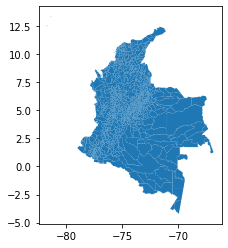

In [10]:
# Geometry
geo_mun.plot() 

In [11]:
# CRS
geo_mun.crs

<Geographic 2D CRS: EPSG:4686>
Name: MAGNA-SIRGAS
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Colombia - onshore and offshore. Includes San Andres y Providencia, Malpelo Islands, Roncador Bank, Serrana Bank and Serranilla Bank.
- bounds: (-84.77, -4.23, -66.87, 15.51)
Datum: Marco Geocentrico Nacional de Referencia
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

### Natural parks data

The national parks data represents the boundaries of restricted and conservations areas under the management of central government envirnmental authorities. Municipalities with area within these limits would have restricted area to host the jaguar ecosystem and greater support from the central government in that matter.

The national park boundaries data is available in [ESRI Open Data Hub](https://datosabiertos.esri.co/datasets/d4d80793ff604f7aa153f3cecbe0757e/explore).

In [12]:
geo_park = gpd.read_file('Data/Parks/Parques_Nacionales_Naturales_de_Colombia.shp')

In [13]:
# Raw data reading
geo_park.head()

,OBJECTID,Id,Nombre,No_Res_Vi,Area_Res,Región,Categoría,Cos_Adulto,Cos_Ninos,Alojamie,Camping,SHAPE_Leng,ShapeSTAre,ShapeSTLen,geometry
0,1,1,EL COCUY,RESOLUCION 0156 DE 06/06/1977,306000.0,Andes Nororientales,Parque Nacional,26000,12500,No,No,4.922499,3.133832e+09,549829.792036,"POLYGON ((-72.27591 6.76498, -72.27742 6.76479..."
1,2,2,PISBA,RESOLUCION 0155 DE 06/06/1977,45000.0,Andes Nororientales,Parque Nacional,None,None,No,No,1.641009,3.738832e+08,183179.822217,"POLYGON ((-72.52926 6.01147, -72.52905 6.01146..."
2,3,3,PARAMILLO,RESOLUCION 0163 DE 06/06/1977,460000.0,Caribe,Parque Nacional,None,None,No,No,6.087042,5.451650e+09,680975.575886,"POLYGON ((-75.72161 7.51973, -75.72368 7.51582..."
3,4,4,MALPELO,RESOLUCION 1292 DE 31/10/1995,974474.0,Pacífico,Santuario de Fauna y Flora,None,None,No,No,3.533329,9.689266e+09,393815.696700,"POLYGON ((-81.13333 4.43333, -81.13333 3.53333..."
4,5,5,SANQUIANGA,RESOLUCION 161 DE 6/06/1977,80000.0,Pacífico,Parque Nacional,None,None,No,No,1.440176,8.726801e+08,160378.891472,"POLYGON ((-78.22278 2.53124, -78.22276 2.53121..."


In [14]:
# Data review
geo_park.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    58 non-null     int64   
 1   Id          58 non-null     int64   
 2   Nombre      58 non-null     object  
 3   No_Res_Vi   58 non-null     object  
 4   Area_Res    58 non-null     float64 
 5   Región      58 non-null     object  
 6   Categoría   58 non-null     object  
 7   Cos_Adulto  19 non-null     object  
 8   Cos_Ninos   19 non-null     object  
 9   Alojamie    58 non-null     object  
 10  Camping     58 non-null     object  
 11  SHAPE_Leng  58 non-null     float64 
 12  ShapeSTAre  58 non-null     float64 
 13  ShapeSTLen  58 non-null     float64 
 14  geometry    58 non-null     geometry
dtypes: float64(4), geometry(1), int64(2), object(8)
memory usage: 6.9+ KB


<AxesSubplot:>

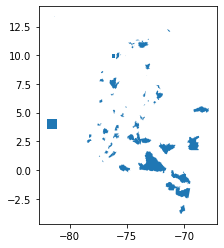

In [15]:
# Geometry
geo_park.plot() 

In [16]:
# CRS
geo_park.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Reading

### Jaguar records

In [17]:
# Set geometry
#geometry = gpd.points_from_xy(raw_jag['longitude'], raw_jag['latitude'])

In [18]:
# Reading geopandas df
geo_jag = gpd.GeoDataFrame(raw_jag, geometry=gpd.points_from_xy(raw_jag.longitude, raw_jag.latitude), crs="EPSG:4326")

In [19]:
# Data reading
geo_jag.head()

,issue,mediaType,license,dateIdentified,family,verbatimScientificNameAuthorship,institutionCode,genus,basisOfRecord,taxonKey,...,year,speciesKey,decimalLongitude,gbifID,order,datasetKey,geometry,stateProvince,longitude,latitude
0,COORDINATE_ROUNDED;INSTITUTION_MATCH_NONE;COLL...,NaN,CC_BY_NC_4_0,1970-01-01T00:00:00.000Z,Felidae,NaN,IIAP,Puma,HUMAN_OBSERVATION,2435099,...,2012,2435099,-76.686556,1503125323,Carnivora,5995e6ec-ec8e-4021-ab7b-37806367c48a,POINT (-76.68656 5.13336),Chocó,-76.686556,5.133361
1,NaN,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",Terrasos,Puma,MACHINE_OBSERVATION,2435099,...,2019,2435099,-73.409921,2556487738,Carnivora,cf557dff-b9cb-4a23-bf74-a927fef0d7b6,POINT (-73.40992 3.55157),Meta,-73.409921,3.551567
2,NaN,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",Terrasos,Puma,MACHINE_OBSERVATION,2435099,...,2020,2435099,-73.409498,3332427318,Carnivora,cf557dff-b9cb-4a23-bf74-a927fef0d7b6,POINT (-73.40950 3.52605),Meta,-73.409498,3.526048
3,INSTITUTION_MATCH_NONE;COLLECTION_MATCH_NONE,NaN,CC_BY_NC_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",PROMIGAS S.A. E.S.P. (Promigas),Puma,HUMAN_OBSERVATION,2435099,...,2017,2435099,-75.189814,3019065673,Carnivora,8c145caa-8dca-40e6-b082-741e0d6b8f83,POINT (-75.18981 10.68638),Atlántico,-75.189814,10.686383
4,GEODETIC_DATUM_ASSUMED_WGS84;COUNTRY_DERIVED_F...,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,NaN,NaN,Puma,PRESERVED_SPECIMEN,2435099,...,1996,2435099,-125.830000,2306925380,Carnivora,ad43e954-dd79-4986-ae34-9ccdbd8bf568,POINT (-125.83000 49.67000),NaN,-125.830000,49.670000


In [20]:
# Data review
geo_jag.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6790 entries, 0 to 6789
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   issue                             6232 non-null   object  
 1   mediaType                         2961 non-null   object  
 2   license                           6790 non-null   object  
 3   dateIdentified                    6790 non-null   object  
 4   family                            6790 non-null   object  
 5   verbatimScientificNameAuthorship  2225 non-null   object  
 6   institutionCode                   6754 non-null   object  
 7   genus                             6790 non-null   object  
 8   basisOfRecord                     6790 non-null   object  
 9   taxonKey                          6790 non-null   int64   
 10  month                             6790 non-null   int64   
 11  individualCount                   1526 non-null 

<AxesSubplot:>

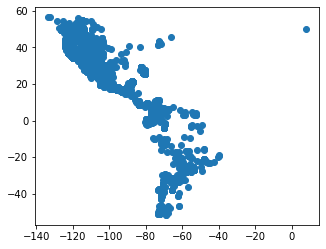

In [21]:
# Geometry
geo_jag.plot() 

In [22]:
# Setting to projected CRS
geo_jag = geo_jag.to_crs(crs="EPSG:21897")

In [23]:
# Review new CRS
geo_jag.crs

<Derived Projected CRS: EPSG:21897>
Name: Bogota 1975 / Colombia Bogota zone
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Colombia - onshore between 1°30'W and 1°30'E of Bogota (75°35'W and 72°35'W of Greenwich).
- bounds: (-75.59, -2.51, -72.58, 11.82)
Coordinate Operation:
- name: Colombia Bogota zone
- method: Transverse Mercator
Datum: Bogota 1975
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

### Municipalties data

In [24]:
# Setting to projected CRS
geo_mun = geo_mun.to_crs(crs="EPSG:21897")

In [25]:
# Review new CRS
geo_mun.crs

<Derived Projected CRS: EPSG:21897>
Name: Bogota 1975 / Colombia Bogota zone
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Colombia - onshore between 1°30'W and 1°30'E of Bogota (75°35'W and 72°35'W of Greenwich).
- bounds: (-75.59, -2.51, -72.58, 11.82)
Coordinate Operation:
- name: Colombia Bogota zone
- method: Transverse Mercator
Datum: Bogota 1975
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

### Natural parks data

In [26]:
# Setting CRS
geo_park = geo_park.to_crs(crs="EPSG:21897")

In [27]:
# Review new CRS
geo_park.crs

<Derived Projected CRS: EPSG:21897>
Name: Bogota 1975 / Colombia Bogota zone
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Colombia - onshore between 1°30'W and 1°30'E of Bogota (75°35'W and 72°35'W of Greenwich).
- bounds: (-75.59, -2.51, -72.58, 11.82)
Coordinate Operation:
- name: Colombia Bogota zone
- method: Transverse Mercator
Datum: Bogota 1975
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

## Subsetting

### Spatial subsetting

In [28]:
geo_jag_col = gpd.clip(geo_jag, geo_mun)

In [29]:
geo_jag_col.shape

(544, 53)

In [30]:
geo_jag_col.head()

,issue,mediaType,license,dateIdentified,family,verbatimScientificNameAuthorship,institutionCode,genus,basisOfRecord,taxonKey,...,year,speciesKey,decimalLongitude,gbifID,order,datasetKey,geometry,stateProvince,longitude,latitude
461,PRESUMED_SWAPPED_COORDINATE;OCCURRENCE_STATUS_...,NaN,CC_BY_4_0,2016-10-11T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",CORMACARENA,Puma,HUMAN_OBSERVATION,2435099,...,2016,2435099,-73.793000,1804707606,Carnivora,bd87ead7-eb08-40ec-8ea3-1a61c134ec56,POINT (1031649.378 741779.679),Meta,-73.793000,2.261000
753,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...,NaN,CC_BY_4_0,2011-01-01T00:00:00.000Z,Felidae,"Linnaeus, 1771",Cormacarena,Puma,HUMAN_OBSERVATION,2435099,...,2011,2435099,-73.369891,1978369766,Carnivora,0fca9cb2-caaa-499d-bf3d-8920c69a3a35,POINT (1078628.824 879188.124),Meta,-73.369891,3.503398
759,OCCURRENCE_STATUS_INFERRED_FROM_INDIVIDUAL_COU...,NaN,CC_BY_4_0,2011-01-01T00:00:00.000Z,Felidae,"Linnaeus, 1771",Cormacarena,Puma,HUMAN_OBSERVATION,2435099,...,2011,2435099,-73.355124,1978369765,Carnivora,0fca9cb2-caaa-499d-bf3d-8920c69a3a35,POINT (1080269.372 879688.583),Meta,-73.355124,3.507912
43,NaN,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",Terrasos,Puma,MACHINE_OBSERVATION,2435099,...,2019,2435099,-73.406327,2382360772,Carnivora,cf557dff-b9cb-4a23-bf74-a927fef0d7b6,POINT (1074578.409 881380.140),Meta,-73.406327,3.523247
2,NaN,NaN,CC_BY_4_0,1970-01-01T00:00:00.000Z,Felidae,"(Linnaeus, 1771)",Terrasos,Puma,MACHINE_OBSERVATION,2435099,...,2020,2435099,-73.409498,3332427318,Carnivora,cf557dff-b9cb-4a23-bf74-a927fef0d7b6,POINT (1074225.828 881689.636),Meta,-73.409498,3.526048


<AxesSubplot:>

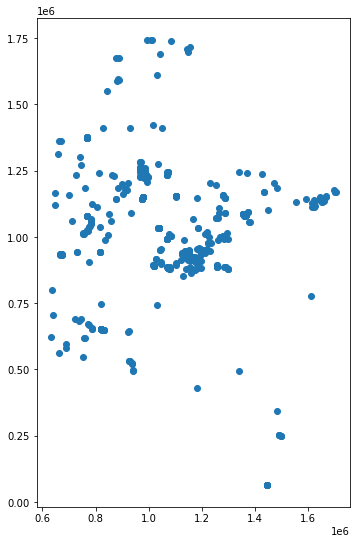

In [31]:
# Geometry
fig, ax = plt.subplots(1,1, figsize=(12,9))
geo_jag_col.plot(ax=ax) 

## Spatial aggregation

### Record count

In [32]:
# Create a record count column
geo_mun['record_count'] = 0

In [33]:
# Count number of record in each municipality
for index, mun in geo_mun.iterrows():
    # Filter points that intersect with the current polygon
    intersecting_points = geo_jag_col[geo_jag_col.intersects(mun.geometry)]
    
    # Count the number of intersecting points
    count = len(intersecting_points)
    
    # Store the count in the 'point_count' column
    geo_mun.loc[index, 'record_count'] = count



In [34]:
geo_mun.head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry,record_count
0,05,001,05001,ANTIOQUIA,MEDELLÍN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((823816.410 1196817.542, 823827.077 1...",0
1,05,002,05002,ANTIOQUIA,ABEJORRAL,1814,507.141095,4,2021,MUNICIPIO,1.158504,0.041384,"POLYGON ((845868.188 1149425.340, 845913.685 1...",0
2,05,004,05004,ANTIOQUIA,ABRIAQUÍ,1912,296.894050,4,2021,MUNICIPIO,0.812183,0.024248,"POLYGON ((778183.219 1238683.337, 778212.466 1...",0
3,05,021,05021,ANTIOQUIA,ALEJANDRÍA,Decreto departamental 304 de 1907,128.932153,4,2021,MUNICIPIO,0.705200,0.010535,"POLYGON ((894267.167 1201318.789, 894274.925 1...",0
4,05,030,05030,ANTIOQUIA,AMAGÁ,1912,84.132675,4,2021,MUNICIPIO,0.445241,0.006867,"POLYGON ((823041.788 1164959.876, 823093.410 1...",0


In [35]:
geo_mun['record_count'].describe()

count    1121.000000
mean        0.485281
std         3.354901
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        71.000000
Name: record_count, dtype: float64

Text(0.5, 1.0, 'Record count')

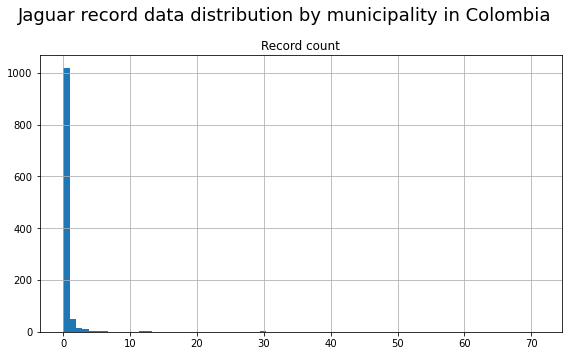

In [36]:
# Plotting by record count
fig, ax = plt.subplots(1,1, figsize=(8,5),tight_layout=True)
plt.suptitle('Jaguar record data distribution by municipality in Colombia',fontsize=18)
geo_mun.hist(column='record_count',ax=ax,bins=75)

# Titles
ax.set_title("Record count",fontsize=12)

In [37]:
# Municipality with highest value of cases
geo_mun[geo_mun.record_count == geo_mun.record_count.max()]

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry,record_count
703,50,573,50573,META,PUERTO LÓPEZ,Decreto 2543 de 1955,6913.346576,4,2021,MUNICIPIO,6.006052,0.562628,"POLYGON ((1213578.203 983048.123, 1213753.993 ...",71


<AxesSubplot:>

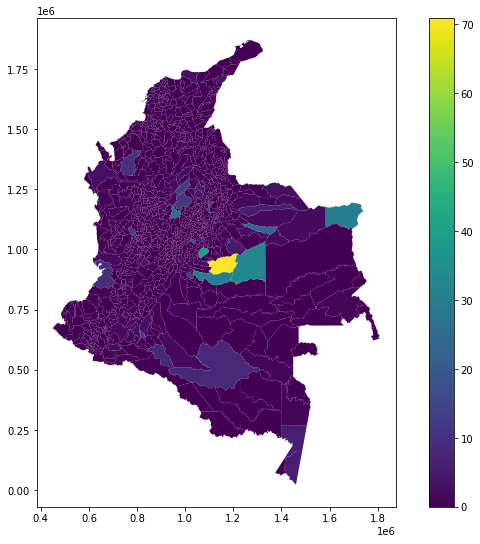

In [109]:
# Plotting by record count
fig, ax = plt.subplots(1,1, figsize=(12,9))
geo_mun.plot(column='record_count',ax=ax,legend=True)

### Record rate

The jaguar record rate (records/area) is a result of the relation of the number of records and the area of each municipality (squared meteres).

__Record date =__ (number of cases) / (squared meters) 

In [39]:
# Creates the new feature
geo_mun['record_rate'] = 0

In [40]:
geo_mun['record_rate'] = (geo_mun.record_count)/(geo_mun.MPIO_NAREA)

In [41]:
geo_mun['record_rate'].describe()

count    1121.000000
mean        0.000477
std         0.003383
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.071324
Name: record_rate, dtype: float64

In [42]:
# Municipality with highest rate
geo_mun[geo_mun.record_rate == geo_mun.record_rate.max()]

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry,record_count,record_rate
494,25,326,25326,CUNDINAMARCA,GUATAVITA,1593,252.369863,4,2021,MUNICIPIO,0.749889,0.020576,"POLYGON ((1026159.157 1042453.150, 1026186.320...",18,0.071324


<AxesSubplot:>

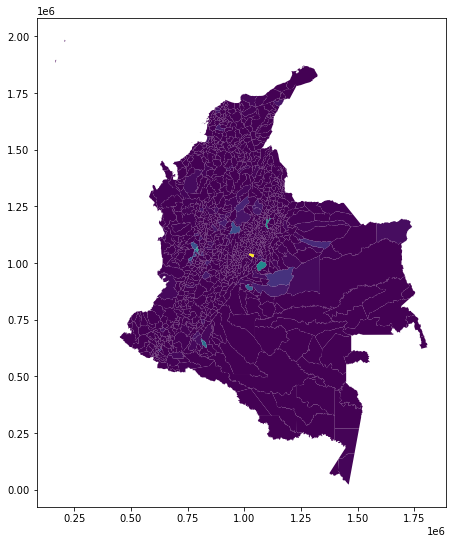

In [43]:
# Plotting by record count
fig, ax = plt.subplots(1,1, figsize=(12,9))
geo_mun.plot(column='record_rate',ax=ax)

## National parks

### Area

In [44]:
# Intersection between mun and park
# intersection_parks = gpd.overlay(geo_mun, geo_park, how='intersection')

**Review resulting geometry**

In [45]:
# # Plotting
# fig, ax = plt.subplots(1,1, figsize=(12,9))
# intersection_parks.plot(ax=ax)

In [46]:
# intersection_parks.head(1)

In [47]:
# # Plotting
# fig, ax = plt.subplots(1,1, figsize=(12,9))
# intersection_parks.head(1).plot(ax=ax)

In [48]:
# geo_mun[geo_mun.MPIO_CDPMP == '05004']

In [49]:
# fig, ax = plt.subplots(1,1, figsize=(12,9))
# geo_mun[geo_mun.MPIO_CDPMP == '05004'].plot(ax=ax)

In [50]:
# Function for calculatins intercepting area percentage
def calculate_intersection_percentage(initial_df, intersecting_df, new_column_name):
    # Create a new column in the initial DataFrame
    initial_df[new_column_name] = None

    # Iterate over each polygon in the initial DataFrame
    for idx, polygon in initial_df.iterrows():
        intersection = initial_df.geometry[idx].intersection(intersecting_df.unary_union)
        intersection_area = intersection.area
        percentage = (intersection_area / initial_df.geometry[idx].area)
        initial_df.at[idx, new_column_name] = float(percentage)
    initial_df[new_column_name] = pd.to_numeric(initial_df[new_column_name])

    return initial_df

In [51]:
geo_mun = calculate_intersection_percentage(geo_mun, geo_park, 'percentage_area_park')

In [52]:
geo_mun.head(3)

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry,record_count,record_rate,percentage_area_park
0,05,001,05001,ANTIOQUIA,MEDELLÍN,1965,374.812877,4,2021,MUNICIPIO,1.032546,0.030606,"POLYGON ((823816.410 1196817.542, 823827.077 1...",0,0.0,0.000000
1,05,002,05002,ANTIOQUIA,ABEJORRAL,1814,507.141095,4,2021,MUNICIPIO,1.158504,0.041384,"POLYGON ((845868.188 1149425.340, 845913.685 1...",0,0.0,0.000000
2,05,004,05004,ANTIOQUIA,ABRIAQUÍ,1912,296.894050,4,2021,MUNICIPIO,0.812183,0.024248,"POLYGON ((778183.219 1238683.337, 778212.466 1...",0,0.0,0.034696


In [53]:
geo_mun.describe()

,MPIO_NAREA,MPIO_VGNC,Shape_Leng,Shape_Area,record_count,record_rate,percentage_area_park
count,1121.000000,1121.0,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000
mean,1017.816485,2021.0,1.482910,0.082813,0.485281,0.000477,0.032454
std,3219.209192,0.0,1.712757,0.260928,3.354901,0.003383,0.101705
min,15.828783,2021.0,0.173409,0.001292,0.000000,0.000000,0.000000
25%,132.755935,2021.0,0.615772,0.010835,0.000000,0.000000,0.000000
50%,287.807945,2021.0,0.970994,0.023515,0.000000,0.000000,0.000000
75%,704.098431,2021.0,1.656029,0.057297,0.000000,0.000000,0.000000
max,65597.250559,2021.0,20.045859,5.308583,71.000000,0.071324,0.866689


In [54]:
geo_mun.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   DPTO_CCDGO            1121 non-null   object  
 1   MPIO_CCDGO            1121 non-null   object  
 2   MPIO_CDPMP            1121 non-null   object  
 3   DPTO_CNMBR            1121 non-null   object  
 4   MPIO_CNMBR            1121 non-null   object  
 5   MPIO_CRSLC            1121 non-null   object  
 6   MPIO_NAREA            1121 non-null   float64 
 7   MPIO_CSMBL            1121 non-null   object  
 8   MPIO_VGNC             1121 non-null   int64   
 9   MPIO_TIPO             1121 non-null   object  
 10  Shape_Leng            1121 non-null   float64 
 11  Shape_Area            1121 non-null   float64 
 12  geometry              1121 non-null   geometry
 13  record_count          1121 non-null   int64   
 14  record_rate           1121 non-null   float64 
 

### Distance

In [55]:
# Controide of each national park polygon

In [56]:
geo_mun['dist_to_p'] = geo_mun.geometry.apply(lambda x: geo_park.centroid.distance(x).min())

In [57]:
geo_mun.describe()

,MPIO_NAREA,MPIO_VGNC,Shape_Leng,Shape_Area,record_count,record_rate,percentage_area_park,dist_to_p
count,1121.000000,1121.0,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000
mean,1017.816485,2021.0,1.482910,0.082813,0.485281,0.000477,0.032454,44129.269421
std,3219.209192,0.0,1.712757,0.260928,3.354901,0.003383,0.101705,30171.668842
min,15.828783,2021.0,0.173409,0.001292,0.000000,0.000000,0.000000,0.000000
25%,132.755935,2021.0,0.615772,0.010835,0.000000,0.000000,0.000000,22147.938908
50%,287.807945,2021.0,0.970994,0.023515,0.000000,0.000000,0.000000,40734.939190
75%,704.098431,2021.0,1.656029,0.057297,0.000000,0.000000,0.000000,62616.806947
max,65597.250559,2021.0,20.045859,5.308583,71.000000,0.071324,0.866689,239661.584712


In [58]:
geo_mun[geo_mun.dist_to_p== 0].head()

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry,record_count,record_rate,percentage_area_park,dist_to_p
48,05,284,05284,ANTIOQUIA,FRONTINO,1859,1384.193295,4,2021,MUNICIPIO,2.389591,0.113029,"POLYGON ((762668.379 1257545.366, 762702.008 1...",1,0.000722,0.156068,0.0
178,13,657,13657,BOLÍVAR,SAN JUAN NEPOMUCENO,1780,631.207965,4,2021,MUNICIPIO,1.662438,0.052030,"POLYGON ((893144.451 1611167.852, 893287.829 1...",3,0.004753,0.016603,0.0
227,15,755,15755,BOYACÁ,SOCOTÁ,1827,603.586388,4,2021,MUNICIPIO,1.198764,0.049259,"POLYGON ((1166744.802 1168590.370, 1166799.078...",0,0.000000,0.489927,0.0
238,15,232,15232,BOYACÁ,CHÍQUIZA,Ordenanza 19 de Diciembre 26 de 1982,116.511813,4,2021,MUNICIPIO,0.507900,0.009509,"POLYGON ((1074962.619 1123704.497, 1075058.480...",0,0.000000,0.227803,0.0
317,15,332,15332,BOYACÁ,GÜICÁN DE LA SIERRA,1799,952.217878,4,2021,MUNICIPIO,1.537702,0.077778,"POLYGON ((1215407.719 1238578.187, 1215457.356...",0,0.000000,0.817489,0.0


In [59]:
geo_mun[geo_mun.dist_to_p== geo_mun.dist_to_p.max()]

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CDPMP,DPTO_CNMBR,MPIO_CNMBR,MPIO_CRSLC,MPIO_NAREA,MPIO_CSMBL,MPIO_VGNC,MPIO_TIPO,Shape_Leng,Shape_Area,geometry,record_count,record_rate,percentage_area_park,dist_to_p
1103,94,885,94885,GUAINÍA,LA GUADALUPE,Resolución 83,1178.870701,4,2021,ÁREA NO MUNICIPALIZADA,1.750811,0.094338,"POLYGON ((1793775.551 677719.174, 1793800.186 ...",0,0.0,0.0,239661.584712


# Spatial clustering

## Normalization of data

Log transformation

In [60]:
# Columns
geo_mun.columns

Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CDPMP', 'DPTO_CNMBR', 'MPIO_CNMBR',
       'MPIO_CRSLC', 'MPIO_NAREA', 'MPIO_CSMBL', 'MPIO_VGNC', 'MPIO_TIPO',
       'Shape_Leng', 'Shape_Area', 'geometry', 'record_count', 'record_rate',
       'percentage_area_park', 'dist_to_p'],
      dtype='object')

In [61]:
# Columns to transform
cols_to_log = list(geo_mun.columns)[-4:]

In [62]:
# Log tranformation
log_x_vars = []
for x in cols_to_log:
    geo_mun[f"log_{x}"] = np.log(geo_mun[x]+1)
    log_x_vars.append(f"log_{x}")

In [63]:
geo_mun.describe()

,MPIO_NAREA,MPIO_VGNC,Shape_Leng,Shape_Area,record_count,record_rate,percentage_area_park,dist_to_p,log_record_count,log_record_rate,log_percentage_area_park,log_dist_to_p
count,1121.000000,1121.0,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000,1121.000000
mean,1017.816485,2021.0,1.482910,0.082813,0.485281,0.000477,0.032454,44129.269421,0.121909,0.000471,0.028036,10.012856
std,3219.209192,0.0,1.712757,0.260928,3.354901,0.003383,0.101705,30171.668842,0.459956,0.003309,0.083846,2.293544
min,15.828783,2021.0,0.173409,0.001292,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,132.755935,2021.0,0.615772,0.010835,0.000000,0.000000,0.000000,22147.938908,0.000000,0.000000,0.000000,10.005545
50%,287.807945,2021.0,0.970994,0.023515,0.000000,0.000000,0.000000,40734.939190,0.000000,0.000000,0.000000,10.614866
75%,704.098431,2021.0,1.656029,0.057297,0.000000,0.000000,0.000000,62616.806947,0.000000,0.000000,0.000000,11.044805
max,65597.250559,2021.0,20.045859,5.308583,71.000000,0.071324,0.866689,239661.584712,4.276666,0.068895,0.624166,12.386987


## Clustering

In [64]:
# Dropping not connected components
geo_mun.drop(geo_mun[geo_mun.MPIO_CDPMP=='88564'].index,inplace=True)
geo_mun.drop(geo_mun[geo_mun.MPIO_CDPMP=='88001'].index,inplace=True)

In [65]:
%%time
# Caluclate the spatial weight object
w = libpysal.weights.Queen.from_dataframe(geo_mun)

CPU times: user 46.3 s, sys: 4.58 s, total: 50.8 s
Wall time: 50.8 s


In [66]:
# Total number of records
geo_mun['record_count'].sum()

544

In [67]:
# Threshold variable
threshold_variable = 'record_count'

### Non-spatial attributes

In [68]:
# Columns to consider in clustering
attributes = list(geo_mun.columns)[-4:]
attributes

['log_record_count',
 'log_record_rate',
 'log_percentage_area_park',
 'log_dist_to_p']

### Case 1

In [69]:
# Minimum threshold on total records percentage
threshold_value_2 = round((geo_mun['record_count'].sum())*0.02)
threshold_value_2

11

In [70]:
%%time
RANDOM_SEED = 123456
np.random.seed(RANDOM_SEED)
model_records_2_percent = MaxP(geo_mun, w, attributes, threshold_variable, threshold_value_2, top_n=3)
model_records_2_percent.solve()

CPU times: user 26min 12s, sys: 840 ms, total: 26min 13s
Wall time: 26min 12s


In [71]:
#Number of clusters
model_records_2_percent.p

27

In [72]:
# Stores clusters results
geo_mun['spatial_max_p_record_2_percent'] = model_records_2_percent.labels_

In [73]:
# Number of municipalities by cluster
# Descending
geo_mun[['spatial_max_p_record_2_percent','MPIO_CDPMP']].groupby('spatial_max_p_record_2_percent').count().sort_values(by='MPIO_CDPMP',ascending=False).head()

,MPIO_CDPMP
spatial_max_p_record_2_percent,
10,102
5,92
24,87
14,73
21,71


In [74]:
# Number of municipalities by cluster
# Ascending
geo_mun[['spatial_max_p_record_2_percent','MPIO_CDPMP']].groupby('spatial_max_p_record_2_percent').count().sort_values(by='MPIO_CDPMP',ascending=True).head()

,MPIO_CDPMP
spatial_max_p_record_2_percent,
4,5
27,6
23,10
26,12
7,16


array([[<AxesSubplot:title={'center':'MPIO_CDPMP'}>]], dtype=object)

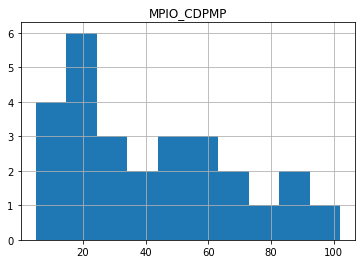

In [75]:
# Histogram of Clustered municipalities
geo_mun[['spatial_max_p_record_2_percent','MPIO_CDPMP']].groupby('spatial_max_p_record_2_percent').count().hist()

In [76]:
# Descriptive statistics of Clustered municipalities
geo_mun[['spatial_max_p_record_2_percent','MPIO_CDPMP']].groupby('spatial_max_p_record_2_percent').count().describe().T

,count,mean,std,min,25%,50%,75%,max
MPIO_CDPMP,27.0,41.444444,27.757651,5.0,19.0,36.0,60.5,102.0


<AxesSubplot:>

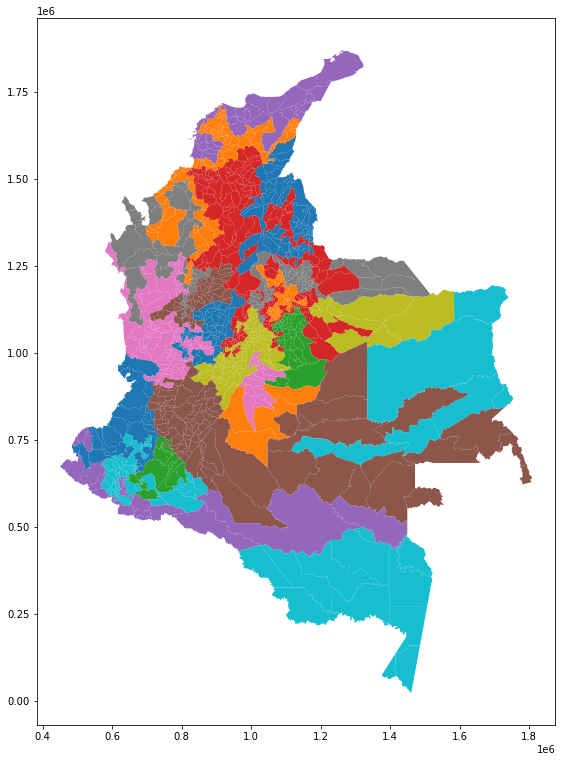

In [77]:
geo_mun.plot(column='spatial_max_p_record_2_percent', categorical=True, figsize=(12,13),linewidth=0.5)

### Case 2

In [78]:
# Minimum threshold on total records percentage
threshold_value_5 = round((geo_mun['record_count'].sum())*0.05)
threshold_value_5

27

In [79]:
%%time
RANDOM_SEED = 123456
np.random.seed(RANDOM_SEED)
model_records_5_percent = MaxP(geo_mun, w, attributes, threshold_variable, threshold_value_5, top_n=3)
model_records_5_percent.solve()

CPU times: user 41min 54s, sys: 1.05 s, total: 41min 55s
Wall time: 41min 53s


In [80]:
#Number of clusters
model_records_5_percent.p

15

In [81]:
# Stores clusters results
geo_mun['spatial_max_p_record_5_percent'] = model_records_5_percent.labels_

In [82]:
# Number of municipalities by cluster
# Descending
geo_mun[['spatial_max_p_record_5_percent','MPIO_CDPMP']].groupby('spatial_max_p_record_5_percent').count().sort_values(by='MPIO_CDPMP',ascending=False).head()

,MPIO_CDPMP
spatial_max_p_record_5_percent,
8,145
3,133
4,124
10,102
11,100


In [83]:
# Number of municipalities by cluster
# Ascending
geo_mun[['spatial_max_p_record_5_percent','MPIO_CDPMP']].groupby('spatial_max_p_record_5_percent').count().sort_values(by='MPIO_CDPMP',ascending=True).head()

,MPIO_CDPMP
spatial_max_p_record_5_percent,
14,15
15,17
9,39
2,44
13,47


array([[<AxesSubplot:title={'center':'MPIO_CDPMP'}>]], dtype=object)

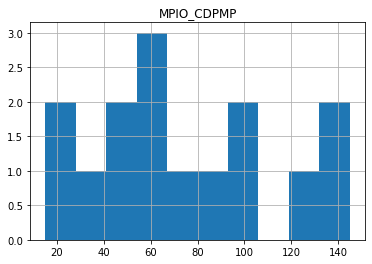

In [84]:
# Histogram of Clustered municipalities
geo_mun[['spatial_max_p_record_5_percent','MPIO_CDPMP']].groupby('spatial_max_p_record_5_percent').count().hist()

In [85]:
# Descriptive statistics of Clustered municipalities
geo_mun[['spatial_max_p_record_5_percent','MPIO_CDPMP']].groupby('spatial_max_p_record_5_percent').count().describe().T

,count,mean,std,min,25%,50%,75%,max
MPIO_CDPMP,15.0,74.6,40.302074,15.0,45.5,63.0,101.0,145.0


<AxesSubplot:>

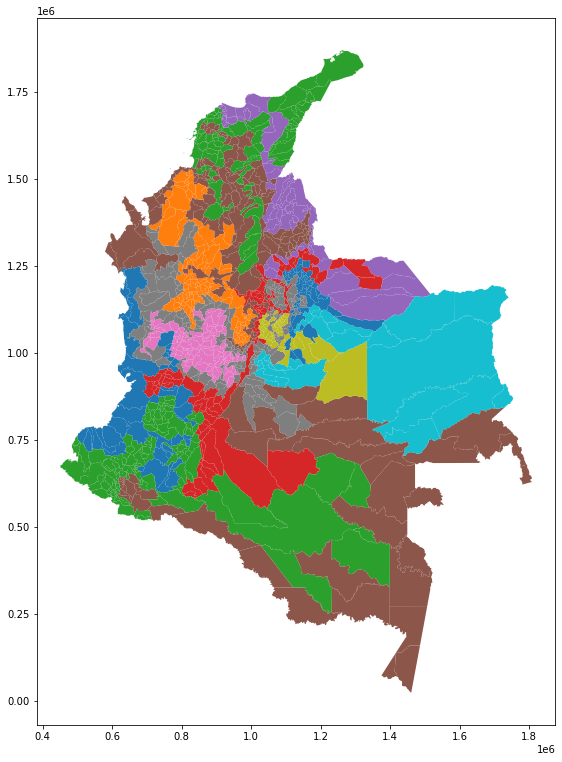

In [86]:
geo_mun.plot(column='spatial_max_p_record_5_percent', categorical=True, figsize=(12,13),linewidth=0.5)

In [127]:
geo_mun.to_file('Results/Municipalities_Jaguar.gpkg', driver='GPKG', layer='Spatial_clustering') 

# Results

Text(0.5, 59.92212868706345, 'Clusters = 15')

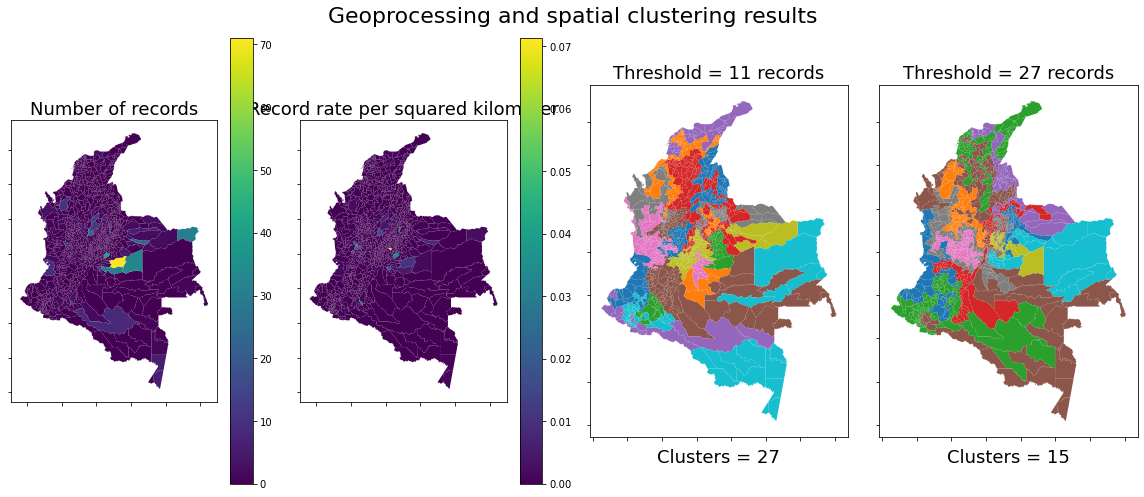

In [111]:
# Ploting spatial clustering results
fig, [ax1,ax2,ax3,ax4] = plt.subplots(1, 4, sharey=False, tight_layout=True,figsize=(16, 7),linewidth=0.5)
plt.suptitle("Geoprocessing and spatial clustering results",fontsize=22)

# Clustering results
geo_mun.plot(column='record_count',linewidth=0.5,ax=ax1,legend=True)
geo_mun.plot(column='record_rate',linewidth=0.5,ax=ax2,legend=True)
geo_mun.plot(column='spatial_max_p_record_2_percent', categorical=True,linewidth=0.5,ax=ax3)
geo_mun.plot(column='spatial_max_p_record_5_percent', categorical=True,linewidth=0.5,ax=ax4)

# Titles
ax1.set_title("Number of records",fontsize=18)
ax2.set_title("Record rate per squared kilometer",fontsize=18)
ax3.set_title("Threshold = 11 records",fontsize=18)
ax4.set_title("Threshold = 27 records",fontsize=18)

# Setting off axis ticks
ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax4.set_yticklabels([])

# legends

# X axis labels
# ax1.set_xlabel("K = "+ str(len(mun_geo_merged_clean_name['DPTO_CCDGO'].unique())),fontsize=18)
# ax2.set_xlabel("K = "+ str(df_spatial_results['Number of clusters'][0]),fontsize=18)
ax3.set_xlabel("Clusters = 27",fontsize=18)
ax4.set_xlabel("Clusters = 15",fontsize=18)

#plt.savefig('Results_Spatial_Population.jpg',dpi=300,bbox_inches='tight')

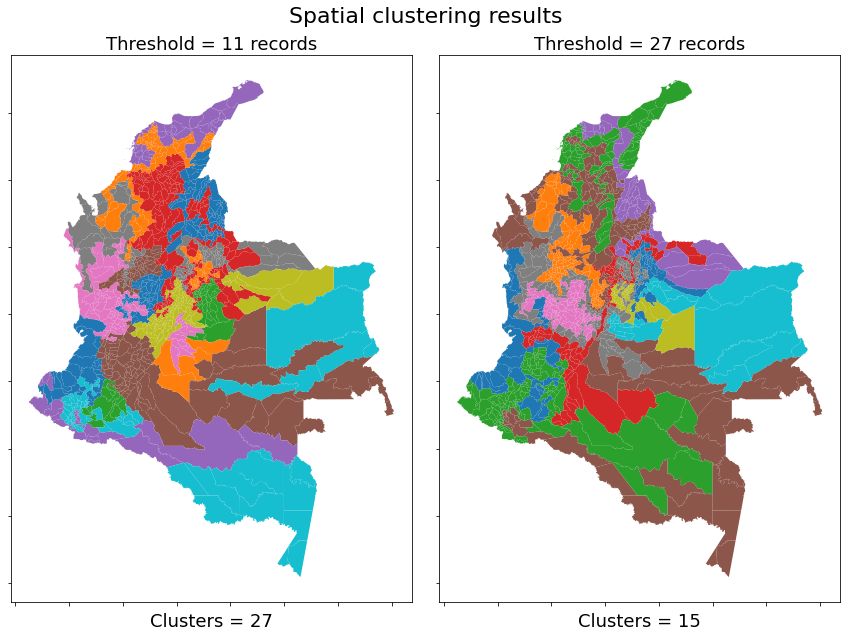

In [126]:
# Ploting spatial clustering results
fig, [ax1,ax2] = plt.subplots(1, 2, sharey=False, tight_layout=True,figsize=(16, 9),linewidth=0.5)
plt.suptitle("Spatial clustering results",fontsize=22)

# Clustering results
# geo_mun.plot(column='record_count',linewidth=0.5,ax=ax1,legend=True)
# geo_mun.plot(column='record_rate',linewidth=0.5,ax=ax2,legend=True)
geo_mun.plot(column='spatial_max_p_record_2_percent', categorical=True,linewidth=0.5,ax=ax1)
geo_mun.plot(column='spatial_max_p_record_5_percent', categorical=True,linewidth=0.5,ax=ax2)

# Titles
# ax1.set_title("Number of records",fontsize=18)
# ax2.set_title("Record rate per squared kilometer",fontsize=18)
ax1.set_title("Threshold = 11 records",fontsize=18)
ax2.set_title("Threshold = 27 records",fontsize=18)

# Setting off axis ticks
ax1.set_xticklabels([])
ax2.set_xticklabels([])
# ax3.set_xticklabels([])
# ax4.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_yticklabels([])
# ax3.set_yticklabels([])
# ax4.set_yticklabels([])

# legends

# X axis labels
# ax1.set_xlabel("K = "+ str(len(mun_geo_merged_clean_name['DPTO_CCDGO'].unique())),fontsize=18)
# ax2.set_xlabel("K = "+ str(df_spatial_results['Number of clusters'][0]),fontsize=18)
ax1.set_xlabel("Clusters = 27",fontsize=18)
ax2.set_xlabel("Clusters = 15",fontsize=18)

plt.savefig('Results/Results_Clustering.jpg',dpi=300,bbox_inches='tight')

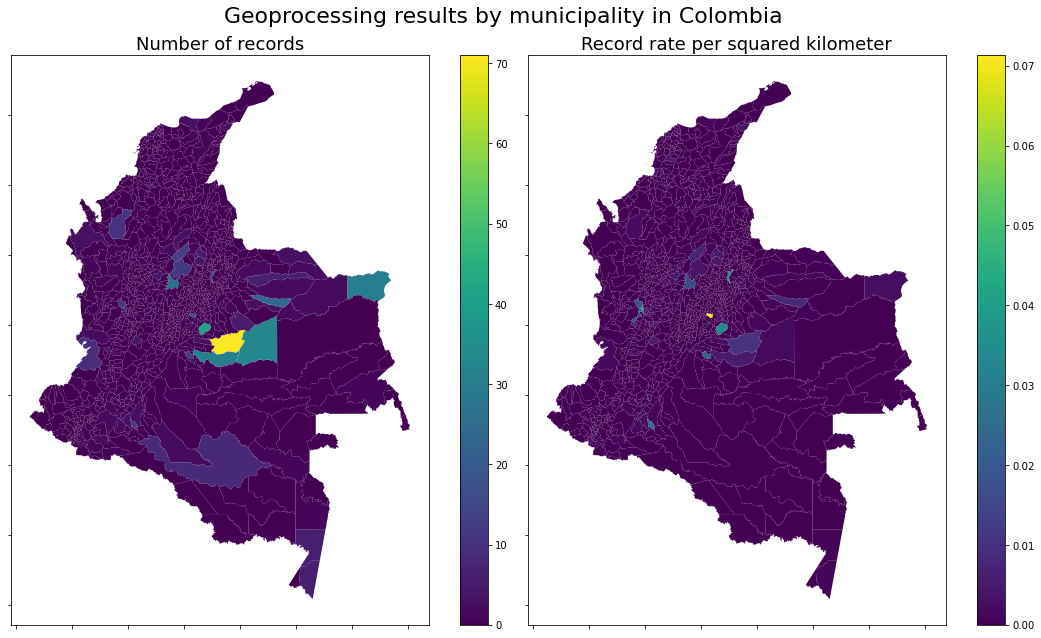

In [123]:
# Ploting spatial clustering results
fig, [ax1,ax2] = plt.subplots(1, 2, sharey=False, tight_layout=True,figsize=(16, 9),linewidth=0.5)
plt.suptitle("Geoprocessing results by municipality in Colombia",fontsize=22)

# Clustering results
geo_mun.plot(column='record_count',linewidth=0.5,ax=ax1,legend=True)
geo_mun.plot(column='record_rate',linewidth=0.5,ax=ax2,legend=True)
#geo_mun.plot(column='spatial_max_p_record_2_percent', categorical=True,linewidth=0.5,ax=ax3)
#geo_mun.plot(column='spatial_max_p_record_5_percent', categorical=True,linewidth=0.5,ax=ax4)

# Titles
ax1.set_title("Number of records",fontsize=18)
ax2.set_title("Record rate per squared kilometer",fontsize=18)
#ax3.set_title("Threshold = 11 records",fontsize=18)
#ax4.set_title("Threshold = 27 records",fontsize=18)

# Setting off axis ticks
ax1.set_xticklabels([])
ax2.set_xticklabels([])
# ax3.set_xticklabels([])
# ax4.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_yticklabels([])
# ax3.set_yticklabels([])
# ax4.set_yticklabels([])

# legends


# X axis labels
# ax1.set_xlabel("K = "+ str(len(mun_geo_merged_clean_name['DPTO_CCDGO'].unique())),fontsize=18)
# ax2.set_xlabel("K = "+ str(df_spatial_results['Number of clusters'][0]),fontsize=18)
# ax3.set_xlabel("Clusters = 27",fontsize=18)
# ax4.set_xlabel("Clusters = 15",fontsize=18)

plt.savefig('Results/Results_Geoprocessing.jpg',dpi=300,bbox_inches='tight')

In [97]:
print('Complete run time: ' + str((timeit.default_timer() - start_time)/60)+' minutes.')

Complete run time: 93.51390762000004 minutes.
